# Recurrent networks with Attention

In labs 7 and 8, we have implemented a seq2seq model based on the encoder-decoder structure, which operates as follows:

- The input sentence (source) is passed as input to the encoder, which compresses the information it contains into a *context vector*, which is the final output of the encoder.
- This context vector is then passed to the decoder, which sequentially decodes and updates it (through its hidden states) and produces the translated output sentence (target).

However, this might be limitting for the decoding part: indeed, at a given step of the decoding process, it might be preferrable to have access to *all* the hidden states from the encoder rather than a single hidden state. This would allow to know which parts of the input sentence are the most relevent to generate the current word in the output sentence.

This can be implemented using a mechanism called **attention**, which is the topic of this lab.

Note: As in the previous labs, we'll talk about context and attention *vectors*. In practice, these are not vectors but tensors, since we operate on batches of data. Nevertheless we'll talk about *vectors* since it is consistent with the underlying theory.

<center><a href="https://medium.com/swlh/a-simple-overview-of-rnn-lstm-and-attention-mechanism-9e844763d07b">
    <img src="https://miro.medium.com/max/2000/1*FP3zFjdFhNUWEJ9hxeIYOA.png" width="800"></a></center>


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
import time
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import spacy
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import copy

## Pre-processing

The pre-processing is the same as in lab 7 and 8, so we provide it.

In [2]:
# German and English specific pipelines
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

# Tokenizers
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Fields
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

# Dataset
train_data, valid_data, test_data = Multi30k.splits(root='data/', exts = ('.de', '.en'), fields = (SRC, TRG))

# Take a subset of the dataset (for speed)
train_data.examples = train_data.examples[:1000]
valid_data.examples = valid_data.examples[:100]
test_data.examples = train_data.examples[:100]

# Vocabulary
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

# Dataloader (here we keep the validation dataloader)
batch_size = 128
train_dataloader, valid_dataloader, test_dataloader = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size = batch_size)

In [3]:
# Index to string functions
def indx2tokens_list(list_indx, field):
    list_tokens = [field.vocab.itos[list_indx[i]] for i in range(len(list_indx))]
    beg_i = list_tokens.index('<sos>')
    if '<eos>' in list_tokens:
        end_i = list_tokens.index('<eos>')
    else:
        end_i = -1
    list_tokens = list_tokens[beg_i+1:end_i]
    return list_tokens

In [5]:
# Fetch one example
example_batch = next(iter(train_dataloader))
print(example_batch.src.shape)

torch.Size([33, 128])


In [6]:
# Define all the parameters of the network (small model for speed)
input_size = len(SRC.vocab)
output_size = len(TRG.vocab)
emb_size_enc = 32
emb_size_dec = 32
hidden_size = 50
n_layers = 1
dropout_rate = 0.5

## GRU encoder

We use a similar encoder to the previous lab. The main difference is that it needs to output the whole sequence of hidden states (not only the final hidden state / context vector) because we will use it in the attention module.

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size_enc, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        # TO DO:
        # - store the input parameters as class attributes
        # - create the embedding, dropout, and GRU layers (the GRU layer does not use recurrent dropout)
        self.input_size = input_size
        self.emb_size_enc = emb_size_enc
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.embedding_layer = nn.Embedding(input_size, emb_size_enc)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.GRU(emb_size_enc, hidden_size, n_layers)

        
    def forward(self, src):
        
        # TO DO:
        # - write the forward pass
        # - return both outputs of the GRU (call them 'enc_outputs' and 'enc_context')
        y = self.embedding_layer(src)
        y = self.dropout(y)
        enc_outputs, enc_context, = self.lstm(y)

        return enc_outputs, enc_context

In [11]:
# TO DO: Instanciate the encoder and print the number of parameters

# TO DO: Apply the encoder to the example batch and print the shapes of the outputs
encoder_lstm = Encoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
enc_outputs, enc_context = encoder_lstm(example_batch.src)
print('Number of parameters:', sum(p.numel() for p in encoder_lstm.parameters()))

Number of parameters: 38264


## The attention mechanism

We now implement the attention mechanism. Intuitively, the idea behind attention is to say which word of the source sentence is the most important to generate the current word at decoding.

Mathematically, let's note $t'$ the current decoding step, $s_{t'-1}$ the previous hidden state of the decoder, and $H = \{h_1, h_2,...,h_T \}$  the set of all encoder outputs at the last layer. The attention vector $a_{t'}$ will therefore be calculated from $s_{t'-1}$ and $H$ through a set of operation with learnable parameters.

### An example

For the very first target token, the previous hidden state is given by $s_0$ = $z$ (= the context vector). The attention mechanism is illustrated below in this case, and we will consider it as example.

<center><a href="https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb">
    <img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/seq2seq9.png" width="500"></a></center>


In [16]:
src_len = enc_outputs.shape[0]

In [15]:
# Take the context vector of the encoder and treat it as the first hidden state to the decoder
dec_hidden = enc_context
dec_hidden.shape

torch.Size([1, 128, 50])

The first step is to assemble / combine the current hidden state of the decoder $s_{t'-1}$ (here, it's simply the context vector) and the encoder outputs into a single tensor. There are many ways to do so (addition, multiplication...), here we simply concatenate them.

**Note**: this is easy to implement when the recurrent part uses 1 layer; otherwise the computation would be more involved as we'd need to consider the extra dimension corresponding to the number of layers. We leave that to further exploration.

Currently (on this example):
- `enc_outputs` has a size of `[src_len, batch_size, hidden_size]`
- `dec_hidden` has a size of `[1, batch_size, hidden_size]`

We want to concatenate them along the last dimension, so first we need to repeat `dec_hidden` along the first dimension `src_len` times. Then, we can perform the concatenation. Finally, we permute the combined tensor so it has a size of `[batch_size, src_len, 2 * hidden_size]`.

In [17]:
# TO DO: compute this concatenation:
# - repeat it using the 'repeat' function (check the doc!)
# - concatenate the features using the 'cat' function
# - permute the dimensions so the resulting combined input has shape [batch_size, src_len, 2*hidden_size]
dec_hidden = dec_hidden.repeat(enc_outputs.shape[0],1,1)
concat_vec = torch.cat([dec_hidden, enc_outputs],dim=2).permute(1, 0, 2)
concat_vec.shape

torch.Size([128, 33, 100])

We then write a network to compute attention from this combined tensor: $a = f(c)$. This network depends on two parameters values, which are:
 - `input_size_att`, which is the length of the input combined tensor, thus it's equal to `2 * hidden_size`.
 - `hidden_size_att`, which corresponds to the intermediate length used in computing the attention vector.

The architecture of the network is as follows:

- a linear layer that goes from size `input_size_att` to `hidden_size_att`
- a tanh activation
- a second linear layer, that goes from size `hidden_size_att` to `1`, and does not use bias
- a softmax layer that acts along `dim=1`, to ensure that the attention vector sums to 1 for every sentence in the batch

In [39]:
# TO DO:
# - define the attention network parameters ('input_size_att', and 'hidden_size_att'=50)
# - write the attention module
# - apply it to the combined input tensor 'comb_inputs'
# - squeeze the output and print its shape
input_size_att = 2*hidden_size
hidden_size_att = 50
attent_net = nn.Sequential(nn.Linear(input_size_att, hidden_size_att),
                            nn.Tanh(), nn.Linear(hidden_size_att, 1), nn.Softmax(dim=1))
attention_output = attent_net(concat_vec)
attention_output.squeeze().shape

torch.Size([128, 33])

### The attention module

Now, we can use what we did above on the example to write the full attention module in the general case.

In [40]:
class Attention(nn.Module):
    def __init__(self, input_size_att, hidden_size_att):
        super().__init__()
        
        # TO DO: store the input parameters as attributes and define the network
        self.input_size_att = input_size_att
        self.hidden_size_att = hidden_size_att
        self.attention = nn.Sequential(nn.Linear(input_size_att, hidden_size_att),
                            nn.Tanh(), nn.Linear(hidden_size_att, 1), nn.Softmax(dim=1))
        
    def forward(self, dec_hidden, enc_outputs):
        
        # TO DO: write the forward method to compute the attention vector
        src_len = enc_outputs.shape[0]
        dec_hidden = dec_hidden.repeat(src_len, 1, 1)
        #print(enc_outputs.shape)
        #print(dec_hidden.shape)
        concat_vec = torch.cat([dec_hidden, enc_outputs], dim=2).permute(1, 0, 2)
        attn = attent_net(concat_vec)
        attn = attn.squeeze()
        return attn

In [41]:
# TO DO:
# - Instanciate an attention module
# - Apply it using dec_hidden and enc_outputs
# - Print the size of the output attention vector 'a'
attention = Attention(input_size_att, hidden_size_att)
a = attention(enc_context, enc_outputs)

In [42]:
a.shape

torch.Size([128, 33])

<span style="color:red">**Q1**</span> Put the size of `a` in your report.

## Decoder with attention

At the decoding step, we can now use the attention vector by applying it to the encoder outputs. This results in the *weighted* vector which is the average of encoder outputs scaled by attention:

$$
w = \sum_t a_t \times h_t
$$

In [52]:
# TO DO: Compute the weighted vector.
# - you need to expand/unsqueeze the attention vector 'a' so it has size [batch_size, 1, src_len]
# - you also need to permute the enc_outputs vector so it has size [batch_size, src_len, hidden_size]
# - perform multiplication using 'torch.bmm' (no need to use a for loop)
# - permute the result so the weighted vector has size [1, batch_size, hidden_dim_dec]
w = torch.bmm(a.unsqueeze(1), enc_outputs.permute(1, 0,2)).permute((1,0,2))
w.shape

torch.Size([1, 128, 50])

Finally, we need to take this weighted vector into account when using the RNN (which here is a GRU). We remind that without attention, the recurrent computation is simply $s_{t'} = \text{GRU}(y_{t'}, s_{t'-1})$ where $y_{t'}$ is the embedding after dropout. When using attention, the formula becomes:

$$
s_{t'} = \text{GRU}([y_{t'}, w], s_{t'-1})
$$

This means the input of the GRU in the decoder is obtained by concatenating the weighted vector with the embedding after dropout $y_{t'}$.

**Note**: using this concatenation changes the size of the GRU input: the input size should no longer be `emb_size_dec` but `emb_size_dec + hidden_size`.

In [71]:
class Decoder(nn.Module):
    def __init__(self, output_size, emb_size_dec, hidden_size, hidden_size_att, n_layers, dropout_rate):
        super().__init__()
        
        # Store input parameters as class attributes
        self.output_size = output_size
        self.emb_size_dec = emb_size_dec
        self.hidden_size = hidden_size
        self.hidden_size_att = hidden_size_att
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.embedding_layer = nn.Embedding(output_size, emb_size_dec)
        # TO DO: Create the decoder layers and the attention module
        self.gru = nn.GRU(emb_size_dec + hidden_size, hidden_size, n_layers)
        self.attention = Attention(2*hidden_size, hidden_size_att)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_idx, input_hidden, enc_outputs):
        
        # Get the embeddings for the input token (same as in the previous lab)
        y = self.dropout_layer(self.embedding_layer(input_idx))
        y = y.unsqueeze(0)
        
        # TO DO:
        # - compute the attention vector
        # - compute the weighted vector
        # - concatenate the embedding (after dropout) and the weighted vector
        # - apply the GRU layer
        # - squeeze the output of the GRU and pass it to the linear layer to have the predicted probabilites
        # - return the predicted probabilites, the hidden state of the GRU, and the attention vector 'a'
        a = attention(input_hidden, enc_outputs)
        #print(a.shape)
        w = torch.bmm(a.unsqueeze(1), enc_outputs.permute(1, 0, 2)).permute(1, 0, 2)
        #print(w.shape)
        concat_vec = torch.cat([y, w], dim=2)

        #print(concat_vec.shape)
        y, hidden_state = self.gru(concat_vec)
        y = y.squeeze()
        y = self.fc_out(y)
        
        return y, hidden_state, a

In [72]:
# Instanciate the decoder, print the number of parameters
decoder = Decoder(output_size, emb_size_dec, hidden_size, hidden_size_att, n_layers, dropout_rate)
print('Number of parameters in the decoder:', sum(p.numel() for p in decoder.parameters()))

# Initialize an input index tensor (corresponds to <sos>)
current_batch_size = a.shape[0]
input_idx = torch.ones(current_batch_size).int() * 2

# Apply the decoder, print the shape of the outputs
pred_proba, hidden, a = decoder(input_idx, enc_context, enc_outputs)

print(enc_context.shape)
print(hidden.shape)
print(a.shape)

Number of parameters in the decoder: 93510
torch.Size([1, 128, 50])
torch.Size([1, 128, 50])
torch.Size([128, 33])


<span style="color:red">**Q2**</span> How many parameters are in the decoder?

## Full model

The full model is the same as in the previous lab. The only difference comes from the fact that we store the attention vector at every step.

In [97]:
# TO DO: write the Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        # Store the encoder, decoder, and the target vocabulary size
        self.encoder = encoder
        self.decoder = decoder
        self.trg_vocab_size = decoder.output_size
        
    def forward(self, src, trg_len):
        
        # Create a tensor to store the predicted probabilities from the decoder
        batch_size = src.shape[-1]
        pred_probas_all = torch.zeros(trg_len, batch_size, self.trg_vocab_size)
        
        # Assign a probability of 1 to the token corresponding to <sos> for the first element
        pred_probas_all[0, :, 2] = 1
        
        # Initialize the first input to the decoder as the <sos> token (coded by '2' in our vocabulary)
        input_idx = torch.ones(batch_size).int() * 2
        
        # TO DO: apply the encoder to the src sentence and get the last hidden and cell states (=context vectors)
        # (these will be used as initial hidden/cell for the decoder)
        enc_outputs, enc_context = self.encoder(src)
        # loop over tokens (note that it starts from 1 -not 0- since the very first token is already known (=<sos>))
        for t in range(1, trg_len):

            # TO DO:
            # - apply the decoder to get the predicted probabilites of the token t (and the updated hidden/cell)
            # - store these predicted probabilities in the 'pred_probas_all' tensor
            # - get the index corresponding to the highest probability for this token: it will be used as the next input index
            output, hidden, a = self.decoder(input_idx, enc_context, enc_outputs)
            input_idx = output.argmax(1)
            pred_probas_all[t,:,:] = output
        return pred_probas_all, a

In [98]:
# Set a random seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Instanciate the full model, apply it to the example_batch, and print the output shapes
encoder = Encoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
decoder = Decoder(output_size, emb_size_dec, hidden_size, hidden_size_att, n_layers, dropout_rate)
model = Seq2Seq(encoder, decoder)
trg_len = example_batch.trg.shape[0]
pred_probas_all, attention_all = model(example_batch.src, trg_len)
print(pred_probas_all.shape)
print(attention_all.shape)

torch.Size([28, 128, 823])
torch.Size([128, 33])


## Training (with validation) and evaluation

We provide below the evaluation and training functions, since they're the same as in the previous lab (except we have to handle the fact that the model returns two outputs: `pred_probas_all` and `attention_all`).

In [99]:
def evaluate_seq2seq(model, eval_dataloader, loss_fn, SEED=1234):

    # Set a random seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    # Set the model in 'eval' mode (disable dropout layer)
    model.eval()

    # Initialize the eval loss
    loss_eval = 0

    # loop over batches
    for i, batch in enumerate(eval_dataloader):

        # Get the source and target sentence, and the target length, copy it to device
        src, trg = batch.src, batch.trg
        trg_len = trg.shape[0]

        # Apply the model
        pred_probas, _ = model(src, trg_len)

        # Remove the first token (always <sos>) to compute the loss
        output_size = pred_probas.shape[-1]
        pred_probas = pred_probas[1:]

        # Reshape the pred_probas and target so that they have appropriate sizes
        pred_probas = pred_probas.view(-1, output_size)
        trg = trg[1:].view(-1)

        # Compute the loss
        loss = loss_fn(pred_probas, trg)

        # Record the loss
        loss_eval += loss.item()

    return loss_eval

In [100]:
def training_val_seq2seq(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True, SEED=1234):

    # Set a random seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()

    # define the optimizer (Adam)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize lists for storing the train and val losses
    loss_train_total = []
    loss_val_total = []
    
    loss_val_optim = float('inf')

    for epoch in range(num_epochs):

        loss_current_epoch = 0

        for i, batch in enumerate(train_dataloader):

            # Get the source and target sentence, and the target length, copy it to device
            src, trg = batch.src, batch.trg
            trg_len = trg.shape[0]

            # Set the gradients at 0
            optimizer.zero_grad()

            # Apply the model
            pred_probas, _ = model_tr(src, trg_len)

            # Remove the first token (always <sos>) to compute the loss
            output_dim = pred_probas.shape[-1]
            pred_probas = pred_probas[1:]

            # Reshape the pred_probas and target
            pred_probas = pred_probas.view(-1, output_dim)
            trg = trg[1:].view(-1)

            # Backpropagation
            loss = loss_fn(pred_probas, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_tr.parameters(), 1.0)
            optimizer.step()

            # Record the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, compute the validation loss
        loss_val = evaluate_seq2seq(model_tr, valid_dataloader, loss_fn)
        
        # Record the training and validation losss over epochs
        loss_train_total.append(loss_current_epoch)
        loss_val_total.append(loss_val)
        
        # Display the training and validation losses
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f} ; Validation loss: {:.4f}'
                   .format(epoch+1, num_epochs, loss_current_epoch, loss_val))
            
        # Save the current model as optimal only if validation loss decreases
        if loss_val<loss_val_optim:
            model_opt = copy.deepcopy(model_tr)
            loss_val_optim = loss_val
                
    return model_opt, loss_train_total, loss_val_total

In [101]:
# Training parameters
num_epochs = 30
learning_rate = 0.001
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
loss_fn = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# Train the model
model_opt, loss_train, loss_val = training_val_seq2seq(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)
torch.save(model_opt.state_dict(), 'model_attention.pt')

Epoch [1/30], Training loss: 53.5103 ; Validation loss: 6.6140
Epoch [2/30], Training loss: 52.5802 ; Validation loss: 6.4413
Epoch [3/30], Training loss: 50.7900 ; Validation loss: 6.0674
Epoch [4/30], Training loss: 47.4231 ; Validation loss: 5.5361
Epoch [5/30], Training loss: 43.4079 ; Validation loss: 5.0169
Epoch [6/30], Training loss: 40.9285 ; Validation loss: 4.7114
Epoch [7/30], Training loss: 38.6270 ; Validation loss: 4.5800
Epoch [8/30], Training loss: 37.9342 ; Validation loss: 4.5011
Epoch [9/30], Training loss: 37.6485 ; Validation loss: 4.4607
Epoch [10/30], Training loss: 37.5373 ; Validation loss: 4.4410
Epoch [11/30], Training loss: 37.4515 ; Validation loss: 4.4330
Epoch [12/30], Training loss: 37.3679 ; Validation loss: 4.4296
Epoch [13/30], Training loss: 37.2961 ; Validation loss: 4.4261
Epoch [14/30], Training loss: 37.2637 ; Validation loss: 4.4226
Epoch [15/30], Training loss: 37.2271 ; Validation loss: 4.4175
Epoch [16/30], Training loss: 37.1891 ; Validatio

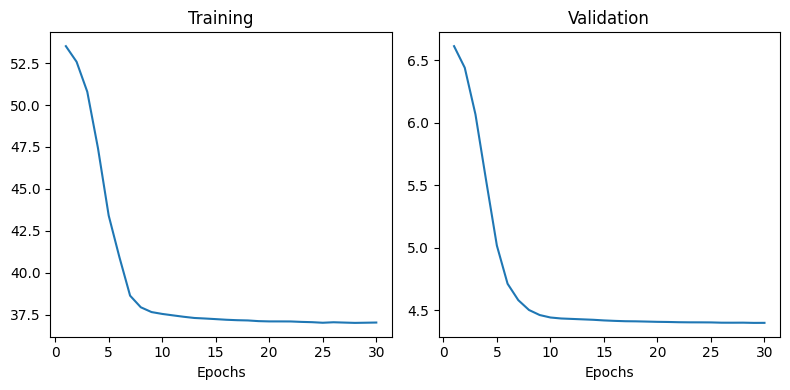

In [102]:
# Plot the training/validation loss
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, loss_train)
plt.xlabel('Epochs')
plt.title('Training')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, loss_val)
plt.xlabel('Epochs')
plt.title('Validation')
plt.tight_layout()
plt.show()

In [103]:
# Evaluate the model on the test set
loss_test = evaluate_seq2seq(model, test_dataloader, loss_fn)
print('Test loss: ', loss_test)

Test loss:  6.700839996337891


<span style="color:red">**Q3**</span> Put the training/validation loss plot in your report.

## Perspectives

Let's quickly check the results in terms of machine translation.

In [104]:
# Get some examples (source and target) in the test set
example_batch_src, example_batch_trg = example_batch.src, example_batch.trg

# Compute predictions with the model
example_batch_trg_pred, _ = model(example_batch_src, len(example_batch_trg))
indx_pred = torch.argmax(example_batch_trg_pred, -1)

# Compute the source, target, and predicted sentence
indx_sentence_print = 1
sentence_src = indx2tokens_list(example_batch_src[:, indx_sentence_print], SRC)
sentence_trg = indx2tokens_list(example_batch_trg[:, indx_sentence_print], TRG)
sentence_pred = indx2tokens_list(indx_pred[:, indx_sentence_print], TRG)

# Print these sentences
print('Source sentence:', sentence_src)
print('Translation - true:', sentence_trg)
print('Translation - predicted:', sentence_pred)

Source sentence: ['eine', 'menschenmenge', 'steht', 'auf', 'einem', '<unk>', ',', 'während', 'ein', 'mann', 'fotografiert', '.']
Translation - true: ['a', 'crowd', 'of', 'people', 'are', 'standing', 'together', 'on', 'a', 'sidewalk', ',', 'while', 'one', 'man', 'is', 'taking', 'a', 'picture', '.']
Translation - predicted: ['each', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy']


As you can see on the example above, the results are not satisfactory. This might be explained by a variety of factors: we only consider a subset of the data; we used a very light network; we didn't conduct training through convergence; we learned token embeddings on-the-fly using one basic layer, etc. However, even if we address these issues specifically, performance will still be limited since we used a rather basic network structure and training protocol.

There are many other strategies to improve performance for such a task (but also for other text processing / NLP tasks based on RNNs - or not):

- using *bi-directionnal* recurrent networks to better account for the whole context of the sentence.
- *skip-filtering*, which means feeding each RNN cell with the whole context vector instead of just the previous hidden state (done [here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/2%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.ipynb)).
- *teacher forcing* in the decoder at training, which means using the ground truth token as input to each decoder cell instead of the predicted token from the previous cell (done [here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)).
- *packed padded sentences* with masking, which allows to skip the `<pad>` token in the encoder and save time (done [here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb)).
- *self-attention*, a key component in [transformers](https://arxiv.org/pdf/1706.03762.pdf), which are state-of-the-art architectures for machine translation (see a simplified version implemented [here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb)).

And many more - research is ongoing!